In [1]:
%%capture
!pip3 install qiskit

# Homework #3

In [2]:
import numpy as np
import qiskit as qk
from sympy import *

In [3]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [4]:
with open('./token', 'r') as token_file:
    token = token_file.read()

In [5]:
%%capture
qk.IBMQ.save_account(token, overwrite = True)
qk.IBMQ.load_account()

In [6]:
provider = qk.IBMQ.get_provider(hub = 'ibm-q')

In [7]:
devices = provider.backends(filters=lambda x: (3 <= x.configuration().n_qubits <= 5) and not x.configuration().simulator)

In [8]:
devices

[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [9]:
simd_backend = qk.Aer.get_backend('qasm_simulator')

## Task \#1

### QFT in general

FFT is Matrix-Vector multiplication of input vector. QFT inherits this form of matrix $\hat Q = \frac{1}{\sqrt{N}} \sum_{jk} e^{i \frac{2\pi}{N} jk} \vert j \rangle \langle k \vert$ in computational basis ($N=2^n$). This matrix is unitary $\hat Q \hat{Q}^\dagger = \hat{I}$.

Since we apply this matrix:
$$\hat{Q} \vert x \rangle = \frac{1}{\sqrt{N}} \sum_{y} e^{i \frac{2\pi}{N} xy} \vert y \rangle = 
\frac{1}{\sqrt{N}} \sum_{y} e^{i 2\pi \vec{x} \sum_j y_j \vec{e}_j / 2^j} \vert y \rangle$$

It can be productized:
$$\hat{Q} \vert x \rangle = \frac{1}{\sqrt{N}} \sum_{y} \Pi_j e^{i 2\pi \vec{x} y_j \vec{e}_j / 2^j} \vert y \rangle = \frac{1}{\sqrt{N}} \otimes_j \left(\vert 0 \rangle + e^{i 2\pi x / 2^j} \vert 1 \rangle \right)$$

Thus we can se how algorithm can be implemented using Hadamard's operators and controlled rotations. 

### Sub-Task \#1 - Shor's algorithm

If target function works on first $n$ bits we can dou le their number. So we'll use $2n$ qbits in circuit.

Let's apply Hadamard's operators to first $n$ qubits:
$$\vert \psi_0 \rangle = (\hat{H}^{\otimes n} \otimes \hat{I}^{\otimes n})(\vert 0 \rangle^{\otimes n} \otimes \vert 0 \rangle^{\otimes n}) = \vert x \rangle \otimes \vert 0 \rangle^{\otimes n},~\vert x \rangle = \frac{1}{\sqrt 2} (\vert 0 \rangle + \vert 1 \rangle)$$
Then we can apply our oracle with function $f(x) = f\big((x + a) \text{mod} 2^n\big)$. It gives us ($x_0=\text{min}\{x: f(x)=z\}$):
$$\vert \psi_1 \rangle = \hat{U}_f \vert \psi_0 \rangle = \vert x \rangle \otimes \vert f(x) \rangle$$

After imagined measurement of the last qbits we'll get:
$$\vert \psi_1 \rangle_m = \sqrt \frac{a}{N} \sum_{x:f(x) = z} \vert x \rangle = \sqrt \frac{a}{N} \sum_{j = 0}^{N/a - 1} \vert x_0 +  j a \rangle$$

Thus we can perform QFT:
$$\hat Q \vert \psi_1 \rangle_m = \frac{1}{\sqrt N} \sqrt \frac{a}{N} \sum_{j=0}^{N/a - 1} \sum_{t=0}^{N-1} \exp\left(\frac{2\pi i}{N} (x_0 + ja)t\right) \vert t \rangle = \frac{\sqrt a}{N} \sum_{t} \exp\left(\frac{2\pi i}{N}x_0 t\right) \sum_{j} \exp\left(\frac{2\pi i}{N}  ja t\right)\vert t \rangle$$

Using result for specific $t^{'} = k N / a,~\forall k \in \mathbb{N}$ we can get:
$$\alpha = \sum_{j} \exp\left(\frac{2\pi i}{N}  ja t^{'}\right) = \frac{N}{a}$$

That gives us possibility to find this peak:
$$P(t) = \frac{a}{N^2} \vert \alpha \vert^2 = \frac{1}{a}$$

Overall probability to find qubit in sych state is:
$$\sum_{t: at=kN} P(t) = a\frac{1}{a} = 1$$

Let's do it for 2 qubits. We'll use simple oracle:

|Before &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;| After &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|-----------------------------|--------------------------------------|
|$\vert 0000 \rangle = \vert 0, 0 \rangle$  | $\vert 0000 \rangle = \vert 0, 0 \rangle$|
|$\vert 0100 \rangle = \vert 1, 0 \rangle$  | $\vert 0101 \rangle = \vert 1, 1 \rangle$|
|$\vert 1000 \rangle = \vert 2, 0 \rangle$  | $\vert 1000 \rangle = \vert 2, 0 \rangle$|
|$\vert 1100 \rangle = \vert 3, 0 \rangle$  | $\vert 1101 \rangle = \vert 3, 1 \rangle$|

In [10]:
qc = qk.QuantumCircuit(4, 2)
qc.h(range(2))
qc.barrier()
#Oracle
qc.cnot(1, 3)
qc.barrier()
#QFT
qc.h(0)
qc.cu1(np.pi / 2, 0, 1)
qc.h(1)
qc.barrier()
qc.measure(range(2), range(2))
qc.draw()

┌───┐ ░       ░ ┌───┐             ░ ┌─┐   
q_0: ┤ H ├─░───────░─┤ H ├─■───────────░─┤M├───
     ├───┤ ░       ░ └───┘ │pi/2 ┌───┐ ░ └╥┘┌─┐
q_1: ┤ H ├─░───■───░───────■─────┤ H ├─░──╫─┤M├
     └───┘ ░   │   ░             └───┘ ░  ║ └╥┘
q_2: ──────░───┼───░───────────────────░──╫──╫─
           ░ ┌─┴─┐ ░                   ░  ║  ║ 
q_3: ──────░─┤ X ├─░───────────────────░──╫──╫─
           ░ └───┘ ░                   ░  ║  ║ 
c: 2/═════════════════════════════════════╩══╩═
                                          0  1

In [11]:
res = qk.execute(qc, backend = simd_backend, shots = 262144).result()

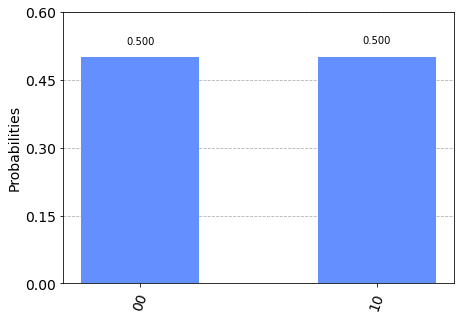

In [12]:
cs = res.get_counts()
plot_histogram(cs)

It gives us right answer. It corresponds 2 values: 0(4) & 2 - as it was predicted.

### Sub-Task \#2 - QFT for 3 qubits

Let's apply QFT to the following state (8 elements length in computational basis) $e^{i \pi / 4} \exp(3 \cdot 2 \pi i \cdot x / 8) + e^{i 3 \pi / 7} \sin(5 \cdot 2 \pi x / 8)$: 

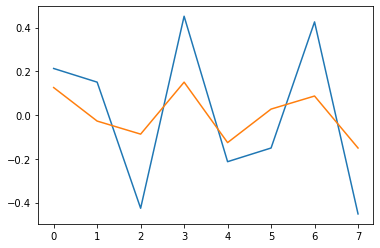

In [13]:
n = 3
nb = 2**n
ns = np.arange(nb)
x0 = 0.75 * np.exp(2 * np.pi * 1j * 3 * ns / 8  - 1j * np.pi / 4) + np.exp(2 * np.pi * 1j * 5 * ns / 8 + 3j * np.pi / 7)
x0 = x0 / np.linalg.norm(x0)
plt.plot(np.real(x0))
plt.plot(np.imag(x0))

In [14]:
qc = qk.QuantumCircuit(3, 3)
qc.initialize(x0, range(3))
qc.barrier()
qc.h(0)
qc.cu1(np.pi / 2, 0, 1)
qc.cu1(np.pi / 4, 0, 2)
qc.h(1)
qc.cu1(np.pi / 2, 1, 2)
qc.h(2)
qc.barrier()
qc.measure(range(3), range(3))

In [15]:
qc.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
c: 3/»
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                                                 ├»
«     │                                                                                                                                                                  │»
«q_1: ┤1 initialize(0.21294+0.12575j,0.15048+-0.027358j,-0.42575+-0.087062j,0.45162+0.15048j,-0.21294+-0.12575j,-0.15048+0.027358j,0.42575+0.087062j,-0.45162+-0.15048j) ├»
«     │                                                                                                                                                                  │»
«q_2: ┤2                                                                                                                                                                 ├»
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«c: 3/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                                                                         »
«      ░ ┌───┐                                ░ ┌─┐      
«q_0: ─░─┤ H ├─■──────■───────────────────────░─┤M├──────
«      ░ └───┘ │pi/2  │     ┌───┐             ░ └╥┘┌─┐   
«q_1: ─░───────■──────┼─────┤ H ├─■───────────░──╫─┤M├───
«      ░              │pi/4 └───┘ │pi/2 ┌───┐ ░  ║ └╥┘┌─┐
«q_2: ─░──────────────■───────────■─────┤ H ├─░──╫──╫─┤M├
«      ░                                └───┘ ░  ║  ║ └╥┘
«c: 3/═══════════════════════════════════════════╩══╩══╩═
«                                                0  1  2

In [16]:
res = qk.execute(qc, backend = simd_backend, shots = 262144).result()

In [17]:
cs = res.get_counts()

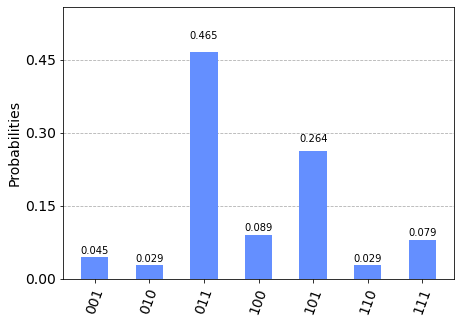

In [18]:
plot_histogram(cs)

In [19]:
#Because of inversed order
ex_ratio = cs['101'] / cs['011']
th_ratio = 0.75**2
ex_ratio / th_ratio

1.0068381112677647

Almost Ideal

## Task \#2

We need to estime $\theta$ after applying 1-qbit rotation operator:
$$\hat{R}(\theta) = 
    \begin{bmatrix}
        1 & 0 \\
        0 & e^{i\theta}
    \end{bmatrix}$$
I.e. $\vert \psi \rangle = \hat{R} \vert 1 \rangle = e^{i \theta} \vert 1 \rangle$.

Let's assume that we work with $n + 1$ qbits $\vert 0 \rangle^{\otimes n} \otimes \vert \psi \rangle$.

After Hadamard's gates on first $n$ qubits we have: $\frac{1}{\sqrt{2^n}} (\vert 0 \rangle + \vert 1 \rangle)^{\otimes n} \otimes \vert \psi \rangle$.

Then we should aaply controlled unitary operations. This operations works if the controlled bit is equal $\vert 1 \rangle$ and gives: $\hat{U}(\theta) \vert \psi \rangle = e^{2\pi i \theta} \vert \psi \rangle$. Thus $\hat{U}^{j} \vert \psi \rangle = \hat{U}^{j-1} \hat{U} \vert \psi \rangle = e^{2\pi i j \theta} \vert \psi \rangle$.

We should apply $\hat{CU}^{2j}$ for pairs $\vert \phi \rangle_j \otimes \vert \psi \rangle$. It will give us:
$$\frac{1}{\sqrt{2^n}} \otimes_j \left(\vert 0 \rangle + e^{2\pi i \theta j} \vert 1 \rangle \right) \otimes \vert \psi \rangle = \frac{1}{\sqrt{2^n}} \sum_j e^{2\pi i \theta j} \vert j \rangle \otimes \vert \psi \rangle$$.

Then we should just apply iQFT:
$$\frac{1}{2^n} \sum_j \sum_k e^{2\pi i k \theta j} e^{-2\pi i j / N} \vert j \rangle \otimes \vert \psi \rangle$$

This dependency has peak at $\theta = j / N$.

Let's work with 3-qubits approximation and $\theta / 2 \pi = 13 / 29$

In [20]:
n = 5
th = 2 * np.pi * 13 / 29
qc = qk.QuantumCircuit(n + 1, n)
#Initialization 
qc.x(n)
qc.barrier()
#{reparation of first qbits
qc.h(range(n))
qc.barrier()
#Controlled unitaries
r = 1
for cq in range(n):
    for i in range(r):
        qc.cu1(th, cq, n)
    r *= 2
qc.barrier()
#iQFT
# Swaps
for q in range(n // 2):
    qc.swap(q, n - 1 - q)
for i in range(n):
    for j in range(i):
        qc.cu1(- np.pi / 2**(i - j), j, i)
    qc.h(i)
qc.barrier()
#Measurements
qc.measure(range(n), range(n))

In [21]:
qc.draw()

░ ┌───┐ ░                                                       »
q_0: ──────░─┤ H ├─░──■────────────────────────────────────────────────────»
           ░ ├───┤ ░  │                                                    »
q_1: ──────░─┤ H ├─░──┼────────■────────■──────────────────────────────────»
           ░ ├───┤ ░  │        │        │                                  »
q_2: ──────░─┤ H ├─░──┼────────┼────────┼────────■────────■────────■───────»
           ░ ├───┤ ░  │        │        │        │        │        │       »
q_3: ──────░─┤ H ├─░──┼────────┼────────┼────────┼────────┼────────┼───────»
           ░ ├───┤ ░  │        │        │        │        │        │       »
q_4: ──────░─┤ H ├─░──┼────────┼────────┼────────┼────────┼────────┼───────»
     ┌───┐ ░ └───┘ ░  │2.8166  │2.8166  │2.8166  │2.8166  │2.8166  │2.8166 »
q_5: ┤ X ├─░───────░──■────────■────────■────────■────────■────────■───────»
     └───┘ ░       ░                                                       »
c: 5/══════════════════════════════════════════════════════════════════════»
                                                                           »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ─■──────────────────────────────────────────────────────────────────────»
«      │                                                                      »
«q_3: ─┼────────■────────■────────■────────■────────■────────■────────■───────»
«      │        │        │        │        │        │        │        │       »
«q_4: ─┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
«      │2.8166  │2.8166  │2.8166  │2.8166  │2.8166  │2.8166  │2.8166  │2.8166 »
«q_5: ─■────────■────────■────────■────────■────────■────────■────────■───────»
«                                                                             »
«c: 5/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ─■──────────────────────────────────────────────────────────────────────»
«      │                                                                      »
«q_4: ─┼────────■────────■────────■────────■────────■────────■────────■───────»
«      │2.8166  │2.8166  │2.8166  │2.8166  │2.8166  │2.8166  │2.8166  │2.8166 »
«q_5: ─■────────■────────■────────■────────■────────■────────■────────■───────»
«                                                                             »
«c: 5/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ──────────────────────────────────────────────────

In [22]:
res = qk.execute(qc, backend = simd_backend, shots = 262144).result()

In [23]:
res

In [24]:
cs = res.get_counts()

In [25]:
def bit_str(x, n):
    body = "{0:b}".format(x)
    return '0' * (n - len(body)) + body

In [26]:
ns = np.arange(2**n)
fs = np.array([cs[bit_str(it, n)] if bit_str(it, n) in cs else 0. for it in ns])
fs = fs / np.sum(fs)

In [27]:
fs

array([0.00077438, 0.00075531, 0.0008049 , 0.00091171, 0.00094986,
       0.00114822, 0.00141144, 0.00175095, 0.00209808, 0.00299072,
       0.00442123, 0.0070343 , 0.01450348, 0.04366684, 0.66718292,
       0.18484116, 0.02898407, 0.01127625, 0.00600433, 0.00358963,
       0.00257492, 0.00214005, 0.00170898, 0.00144196, 0.00122833,
       0.00105667, 0.00095367, 0.00085449, 0.00067902, 0.00072479,
       0.00076294, 0.00077438])

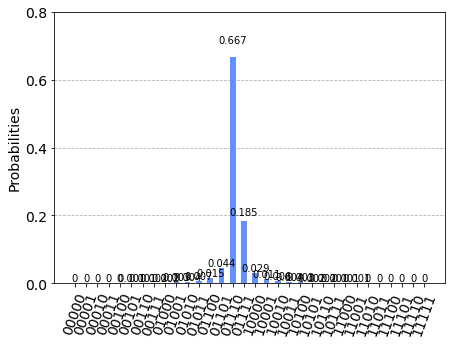

In [28]:
plot_histogram(cs)

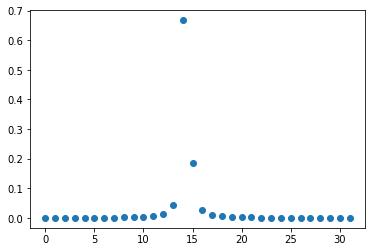

In [29]:
plt.scatter(ns, fs)

In [30]:
def model(theta, nq):
    nb = 2**nq
    xs = np.arange(nb)
    res = np.zeros(nb, dtype = 'complex128')
    for j in range(nb):
        for k in range(nb):
            res[j] += np.exp(2j * np.pi * k * (theta - j / nb))
    return res

In [31]:
def sq_mod(theta, nq):
    r = model(theta, nq)
    sr = np.real(np.conjugate(r) * r).astype(dtype = 'float64')
    return sr / np.sum(sr)

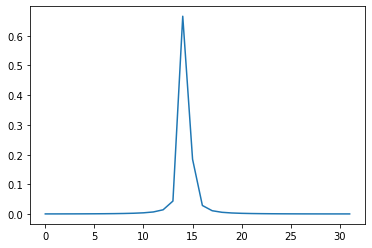

In [32]:
plt.plot(sq_mod(13 / 29, n))

In [33]:
from scipy.optimize import *

In [34]:
init_guess = float(np.argmax(fs) / 2**n)
dfs = fs.astype(dtype = 'float64')
dsqm = lambda x: np.sum((dfs - sq_mod(x, n))**2)
opt_res = minimize(dsqm, init_guess, method = 'CG')

In [35]:
opt_res

     fun: 2.147899039334766e-06
     jac: array([-1.75209607e-08])
 message: 'Optimization terminated successfully.'
    nfev: 22
     nit: 1
    njev: 11
  status: 0
 success: True
       x: array([0.44825606])

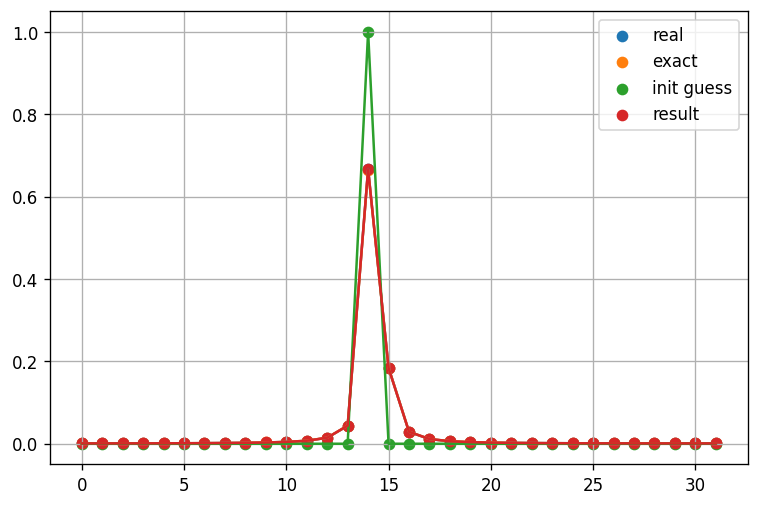

In [36]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.scatter(ns, fs, label = 'real')
plt.plot(ns, fs)
plt.scatter(ns, sq_mod(13 / 29, n), label = 'exact')
plt.plot(ns, sq_mod(13 / 29, n))
plt.scatter(ns, sq_mod(init_guess, n), label = 'init guess')
plt.plot(ns, sq_mod(init_guess, n))
plt.scatter(ns, sq_mod(opt_res['x'], n), label = 'result')
plt.plot(ns, sq_mod(opt_res['x'] , n))
plt.legend()
plt.grid()

We have very realistic result

In [37]:
opt_res['x'] - 13 / 29

array([-1.98017983e-05])